## Backtesting with an SMA- and MACD-Based Strategy for Swing Trading
### with Stop Losses & Target Profits

This is an example of how a simple algorithmic trading strategy based on SMA (Simple Moving Average) and MACD (Moving Average Converge Divergence) can be implemented for backtesting and to calculate the expected returns. In addition, Stop Losses (SL) and Target Profits (TP) are also used to define our exits. The SL and TP are set based on the Average True Range (ATR) value upon entry.

The strategy is as follows:
- Entry Signal: Close Price > SMA200 and MACD histogram > 0
- Exit Signal: when the SL or TP are hit
- SL = entry price - 2 * entry ATR
- TP = entry price + 3 * entry ATR

As an example, the strategy will be applied on the daily share price data from 2018 - 2023 scraped from Yahoo Finance for GlaxoSmithKline stock ([GSK.L](https://uk.finance.yahoo.com/quote/GSK.L/history/)) (as listed on the London Stock Exchange). In this simple strategy, we are only going to go long when a signal arises & sell when our SL or TP is hit (we're not going to short anything at this point). Fees, spread and slippage have not been accounted for.

**Disclaimer:**
- This code is for *educational purposes only*. Please do your own due diligence & trade at your own discretion. The code can be used a starting point to develop more advanced backtesting strategies, but please don't use it in its current form to execute real trades in the financial markets using your own hard-earned cash (or, worse, someone else's cash).

### Section 1 - Load Data & Indicator Calculations

In [1]:
# import relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yfin
import datetime as dt
plt.style.use('bmh')
%matplotlib inline

In [2]:
# get the close prices for the stock

start_date = dt.datetime(2018,4,16)
end_date = dt.datetime(2023,4,15)

yfin.pdr_override()

# create a dataframe for VRTX stock to test the strategy
df = pdr.get_data_yahoo('GSK.L', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [3]:
# check the dataframe
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-04-16 00:00:00+01:00,1434.880249,1437.297974,1412.516968,1418.964111,1051.669556,8476269
2018-04-17 00:00:00+01:00,1421.583252,1425.411255,1409.696411,1422.993530,1054.656128,7119895
2018-04-18 00:00:00+01:00,1426.418457,1437.700928,1417.755249,1432.059692,1061.375366,11550718
2018-04-19 00:00:00+01:00,1434.275879,1434.477417,1414.531738,1417.755249,1050.773560,7421527
2018-04-20 00:00:00+01:00,1429.440552,1445.558350,1424.605347,1440.521484,1067.646973,9710817


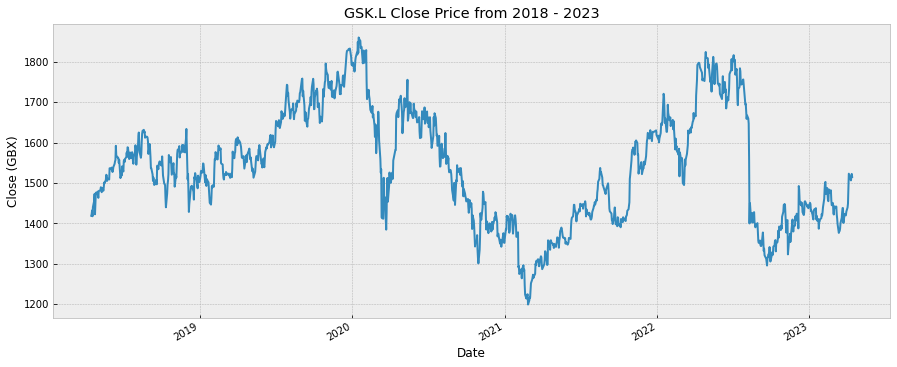

In [4]:
# quick check of the overall price trend
df['Close'].plot(figsize = (15, 6))
plt.title('GSK.L Close Price from 2018 - 2023')
plt.ylabel('Close (GBX)')
plt.show()

### Section 2 - Technical Analysis Indicators
In this section, functions to calculate SMA, MACD and ATR are defined.

In [5]:
# Define the function for SMA

def SMA(data):

    window_size = 200
    data['SMA200'] = data['Close'].rolling(window = window_size, min_periods=window_size).mean() # SMA200

    return(data)

In [6]:
# Define the function for MACD

def MACD(data):

    slow_ema = 26
    fast_ema = 12
    smooth_ema = 9

    data['slow_EMA'] = data['Close'].ewm(span=slow_ema, adjust=False, min_periods=slow_ema).mean()
    data['fast_EMA'] = data['Close'].ewm(span=fast_ema, adjust=False, min_periods=fast_ema).mean()

    # generate MACD, signal lines & the histogram
    data['MACD'] = data['fast_EMA'] - data['slow_EMA']
    data['MACD_Signal'] = data['MACD'].ewm(span=smooth_ema, adjust=False, min_periods=smooth_ema).mean()
    data['MACD_Histogram'] = data['MACD'] - data['MACD_Signal']

    return(data)

In [7]:
# Define a function for ATR

def ATR(data):

    atr_period = 14
    
    data['High_Low'] = data['High'] - data['Low']
    data['High_Close'] = np.absolute(data['High'] - data['Close'].shift(1))
    data['Low_Close'] = np.absolute(data['Low'] - data['Close'].shift(1))
    data['True_Range'] = data[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)
    data['ATR'] = data['True_Range'].rolling(window = atr_period, min_periods = atr_period).mean()

    return(data)

In [8]:
df = SMA(df)
df = MACD(df)
df = ATR(df)

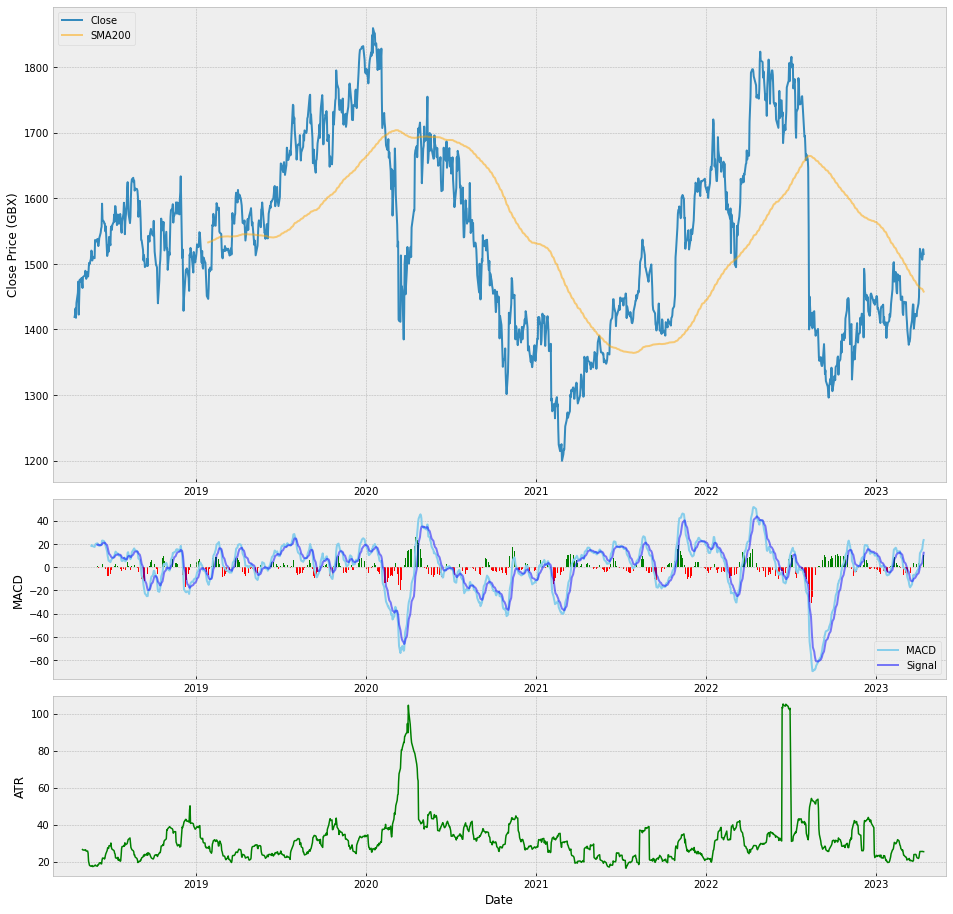

In [9]:
# visualise close price, SMA200, MACD & ATR

start_date = np.datetime64('2018-03-01')
end_date = np.datetime64('2023-06-01')

fig = plt.subplots(figsize=(16,16))
ax1 = plt.subplot2grid((9,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((9,1), (5,0), rowspan = 2, colspan = 1)
ax3 = plt.subplot2grid((9,1), (7,0), rowspan = 2, colspan = 1)

# visualisation of close price & EMAs overlaid on them
ax1.plot(df['Close'], label='Close')
ax1.plot(df['SMA200'], label='SMA200', c='orange', alpha=0.5)
ax1.set_ylabel('Close Price (GBX)')
ax1.set_xbound(lower = start_date, upper = end_date)
ax1.legend(loc='upper left')

# visualisation of MACD lines
ax2.plot(df['MACD'], color='skyblue', label='MACD')
ax2.plot(df['MACD_Signal'], color='blue', alpha=0.5, label='Signal')

# visualisation of MACD histogram
for i in range(len(df['Close'])):
    if df['MACD_Histogram'][i] < 0:
        ax2.bar(df.index[i], df['MACD_Histogram'][i], color='red')
    else:
        ax2.bar(df.index[i], df['MACD_Histogram'][i], color='green')

ax2.set_ylabel('MACD')
ax2.set_xbound(lower = start_date, upper = end_date)
ax2.legend(loc='lower right')

# visualisation of ATR
ax3.plot(df['ATR'], color = 'green', linewidth = 1.5, label = 'ATR')
ax3.set_xbound(lower = start_date, upper = end_date)
ax3.set_ylabel('ATR')
ax3.set_xlabel('Date')

plt.show()

### Section 2 - Trading Strategy

In [10]:
# copy df for the with SL strategy
df2 = df.copy()

Trading strategy:
- Buy --> MACD histogram > 0 and price > EMA200
- Sell --> just let SL (Stop Loss) & TP (Target Profit) take care of exits
- SL & TP are ATR-based (reward : risk ratio = 1.5)

In [11]:
def strategy(data):

    position = 0
    buy_price = []
    sell_price = []
    SL = 0
    TP = 0

    for i in range(len(data)):
        if (data['MACD_Histogram'][i] > 0) and (data['Close'][i] > data['SMA200'][i]) and (position == 0):
            position = 1
            SL = data['Close'][i] - (2 * data['ATR'][i])
            TP = data['Close'][i] + (3 * data['ATR'][i])
            buy_price.append(data['Close'][i])
            sell_price.append(np.nan)

        elif (position == 1) and ((data['Close'][i] < SL) or (data['Close'][i] > TP)):
            position = 0
            SL = 0
            TP = 0
            sell_price.append(data['Close'][i])
            buy_price.append(np.nan)

        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)

    return(buy_price, sell_price)

In [12]:
# call the strategy function to determine buy & sell signals
buy_price, sell_price = strategy(df2)
df2['Buy'] = buy_price
df2['Sell'] = sell_price

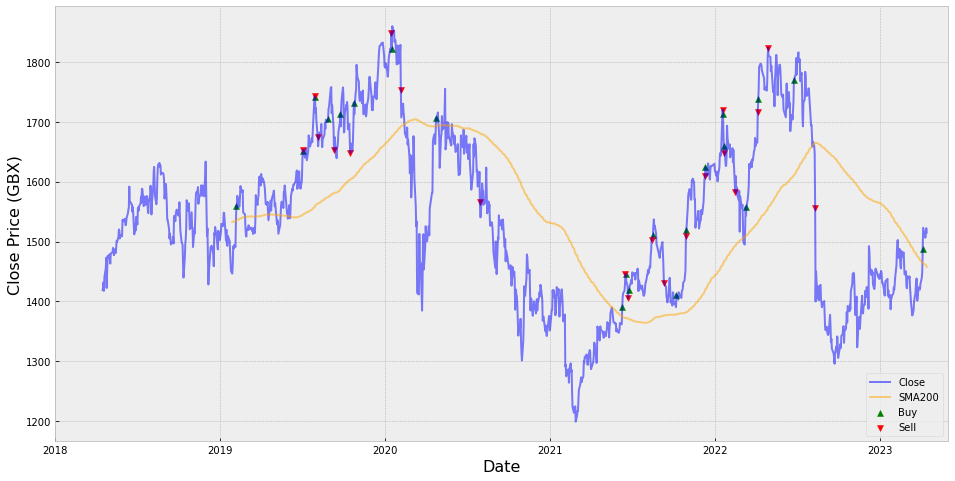

In [13]:
# visualise the buy & sell signals on the price chart
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(df2['Close'], label='Close', c='blue', alpha=0.5)
ax.plot(df2['SMA200'], label='SMA200',  c='orange', alpha=0.5)
ax.scatter(df2.index, df2['Buy'], label = 'Buy', alpha = 1, marker = '^', color = 'green')
ax.scatter(df2.index, df2['Sell'], label = 'Sell', alpha = 1, marker = 'v', color = 'red')
plt.xlim(left=np.datetime64('2018-01-01'), right=np.datetime64('2023-05-31'))
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price (GBX)', fontsize=16)
plt.legend(loc='lower right')
plt.show()

A quick glance at the graph above shows that the number of trades is not that many. We're mostly out from early 2020 to early 2021 when the price was in a downtrend. This is expected since we use the SMA200 as a long-term trend filter. It looks like the strategy keeps us from overtrading (compared to, for example if we only rely on MACD and RSI such as in [my previous example](https://github.com/R-Budhidarmo/MACD-RSI-Strategy)). 

### Section 3 - P & L Calculations

In this section, we'll calculate the overall profit / loss generated using the strategy. The assumptions are as follows:
- our starting capital is GBP 10,000 
- our position size per trade is GBP 200 (i.e. 2% of starting capital)
- we use 50 x leverage per trade
- Fees, spreads & slippage have not been taken into account

In [14]:
# make a list all prices in all instances of buy trades
buy_prices2 = list(df2['Buy'].dropna())

# count the total number of buy trades
print(f"The total number of buy trades: {len(buy_prices2)}")

# sum the total prices at buy trades
print(f"The sum total of prices in all buy trades: {sum(buy_prices2)}")

The total number of buy trades: 21
The sum total of prices in all buy trades: 33874.958984375


In [15]:
# make a list all prices in all instances of sell trades
sell_prices2 = list(df2['Sell'].dropna())

# count the total number of sell trades
print(f"The total number of sell trades: {len(sell_prices2)}")

# sum the total prices at sell trades
print(f"The sum total of prices in all sell trades: {sum(sell_prices2)}")

The total number of sell trades: 20
The sum total of prices in all sell trades: 32490.741821289062


There are 21 entry transactions and 20 exit transactions, indicating that the last entry trade has not been closed. So let's assume we'll sell at the end of the the period.

In [16]:
# append the last close price to the sell_prices list
sell_prices2.append(df2['Close'][-1])

# re-count the total number of sell trades
print(f"The total number of sell trades: {len(sell_prices2)}")

# recalculate the sum of the total prices at sell trades
print(f"The sum total of prices in all sell trades: {sum(sell_prices2)}")

The total number of sell trades: 21
The sum total of prices in all sell trades: 34005.74182128906


In [17]:
# define the position size per trade & leverage
initial_investment = 10000
size_per_trade = 200
leverage = 50

# calculate the differences between entry & exit price for every trade
PnL = pd.DataFrame({'Buy': buy_prices2, 'Sell': sell_prices2})
PnL['Difference'] = PnL['Sell'] - PnL['Buy']

# calculate the number of units of stocks bought for every trade with and without leverage
PnL['Units Bought'] = size_per_trade / PnL['Buy']
PnL['Units Bought_leveraged'] = (size_per_trade*leverage) / PnL['Buy']

# calculate P/L per trade
PnL['PnL'] = (PnL['Sell'] * PnL['Units Bought']) - size_per_trade
PnL['PnL_leveraged'] = (PnL['Sell'] * PnL['Units Bought_leveraged']) - (size_per_trade * leverage)

# calculate cumulative P/L over time
PnL['Cumul_PnL'] = PnL['PnL'].cumsum()
PnL['Cumul_PnL_leveraged'] = PnL['PnL_leveraged'].cumsum()

# calculate the capital growth over time
PnL['Investment_Value'] = initial_investment + PnL['Cumul_PnL']
PnL['Investment_Value_leveraged'] = initial_investment + PnL['Cumul_PnL_leveraged']

Now, to gain a better idea of the performance, we'll plot the value of our capital after every trade (with 50 x leverage).

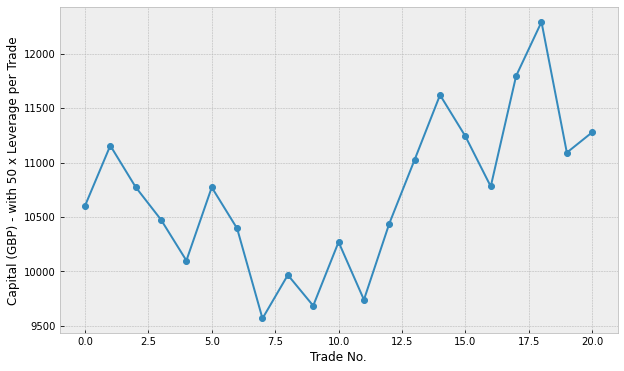

In [18]:
PnL['Investment_Value_leveraged'].plot(figsize=(10,6), marker = 'o')
plt.ylabel('Capital (GBP) - with 50 x Leverage per Trade')
plt.xlabel('Trade No.')
plt.show()

With this strategy, we generally lost money for around the first 10 trades. Only in the last 10 trades that we started makiing some profits. However, the drawdown doesn't seem to be as much as in my previous MACD- & RSI-based [strategy](https://github.com/R-Budhidarmo/MACD-RSI-Strategy). Now, we'll calculate the maximum drawdowns and the actual gains by the end of the period.

In [19]:
# drawdown calculations

drawdown = round(PnL['Cumul_PnL'].min(), 2)
drawdown_leveraged = round(PnL['Cumul_PnL_leveraged'].min(), 2)

# calculations of capital value by the end of period

end_value = round(initial_investment + (PnL['PnL'].sum()), 2)
end_value_leveraged = round(initial_investment + (PnL['PnL_leveraged'].sum()), 2)

# calculations of percent gained / lost by the end of period

pct_end_gain = round(((PnL['Cumul_PnL'].iloc[-1]) / initial_investment) * 100, 2)
pct_end_gain_leveraged = round(((PnL['Cumul_PnL_leveraged'].iloc[-1]) / initial_investment) * 100, 2)

# Calculations of buy-and-hold (BH) strategy P/L

BH_entry_price = df['Close'].iloc[0]
BH_exit_price = df['Close'].iloc[-1]

BH_no_of_units = (initial_investment * 100) / BH_entry_price
BH_end_value = round((BH_exit_price * BH_no_of_units) / 100, 2)
BH_pct_end_gain = round(((BH_end_value - initial_investment) / initial_investment) * 100, 2)

print(f'Maximum drawdown (without using leverage): GBP {drawdown}')
print(f'Maximum drawdown (using 50 x leverage): GBP {drawdown_leveraged}')
print('---------------------------------------------------------------------------------')
print(f'Percent gain by the end of period (without using leverage): {pct_end_gain} %')
print(f'Percent gain by the end of period (using 50 x leverage): {pct_end_gain_leveraged} %')
print(f'Percent gain by the end of period (buy-and-hold): {BH_pct_end_gain} %')
print('---------------------------------------------------------------------------------')
print(f'Capital by the end of period (without using leverage): GBP {end_value}')
print(f'Capital by the end of period (using 50 x leverage): GBP {end_value_leveraged}')
print(f'Capital by the end of period (buy-and-hold): GBP {BH_end_value}')

Maximum drawdown (without using leverage): GBP -8.65
Maximum drawdown (using 50 x leverage): GBP -432.4
---------------------------------------------------------------------------------
Percent gain by the end of period (without using leverage): 0.26 %
Percent gain by the end of period (using 50 x leverage): 12.8 %
Percent gain by the end of period (buy-and-hold): 6.77 %
---------------------------------------------------------------------------------
Capital by the end of period (without using leverage): GBP 10025.59
Capital by the end of period (using 50 x leverage): GBP 11279.69
Capital by the end of period (buy-and-hold): GBP 10676.8


**Conclusions:**
- Although we only lost around GBP 8 throughout the period, when we use 50 x leverage, the maximum drawdown was more than GBP 400 as expected since using leverage magnifies all gains and losses. This is in constrast to my previous [strategy](https://github.com/R-Budhidarmo/MACD-RSI-Strategy) where the maximum drawdown was more than GBP 3000.
- At the end of the period, the value of our capital had gone up only slightly by the end of the period: + 0.26% (+ GBP 25.59) without leverage, or + 12.8% (+ GBP 1279.69) with 50 x leverage. In contrast, if we simply buy and hold, we would've gained 6.8% (+ GBP 676.8) by the end of the period.
- We gain around 13% after 5 years of trading if we use 50 x leverage (which comes with its own associated risks, such as a larger drawdown and fees incurred - which have not been covered here).
- The gains are similar compared to my previous MACD- & RSI-based [strategy](https://github.com/R-Budhidarmo/MACD-RSI-Strategy). However, the maximum drawdown doesn't seem to be as painful. This is important since the first goal of trading is capital preservation before growth. This example may be an indication that including a long-term trend filter, such as SMA200, and stop losses (SL) can be helpful to keep us from over-trading (& incurring larger drawdowns).
- Again, the choice of GSK stock here was deliberate because its price movements sometimes don't really follow a long-term trend and can be choppy. Therefore, the use of SMA & MACD (which are lagging trend-following indicators) may not be optimal for this stock (plus, biotech / healthcare stock price movements are usually determined by fundamentals (e.g. news catalysts) not technicals).